# **Реализация байесовской регрессии с использованием Python**

## Задание

Провести байесовский анализ данных, используя библиотеку Pyro, для оценки параметров линейной регрессии и создания визуализации постериорных распределений. Используйте предоставленный код и выполните следующие шаги:

1. Сгенерировать симулированные данные:
   - Создайте симулированные данные `X` и `Y` с линейной зависимостью и добавлением случайного шума.

2. Определить байесовскую модель регрессии:
   - Определите априорные распределения для параметров регрессии: наклон (`slope`), пересечение (`intercept`) и стандартное отклонение (`sigma`).
   - Опишите ожидаемое значение для зависимой переменной `mu`.
   - Задайте правдоподобие (распределение выборки) для наблюдений.

3. Выполнить байесовский вывод с использованием метода стохастической вариационной инференции (SVI):
   - Определите аппроксимирующие постериорные распределения для параметров.
   - Инициализируйте оптимизатор и SVI.
   - Запустите цикл вывода в течение `num_iterations` и отслеживайте функцию потерь.

4. Получить выборки из постериорного распределения с использованием Predictive:
   - Используйте `Predictive` для получения постериорных выборок параметров модели.

5. Вычислить средние значения параметров:
   - Вычислите средние значения для наклона (`slope`), пересечения (`intercept`) и стандартного отклонения (`sigma`) из полученных выборок.

6. Вывести оцененные параметры:
   - Вывести оцененные значения наклона, пересечения и стандартного отклонения.

7. Создать графики распределений параметров:
   - Построить три подграфика, отображающих постериорные распределения наклона, пересечения и стандартного отклонения.

8. Отобразить результаты:
   - Отобразить графики постериорных распределений параметров и вычисленные оценки параметров.

C помощью пакетного менеджера pip установим неоходимую библиотеку pyro, пердназначенную для глубокого обучения и байесовского моделирования

## **Реализация**

In [ ]:
!pip install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 7.0 MB/s eta 0:00:00


Импортируем необходимые библиотеки

In [ ]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
import matplotlib.pyplot as plt
import seaborn as sns

Зафиксируем генератор случайных чисел

In [ ]:
torch.manual_seed(0)

Сгенерируем данные

In [ ]:
true_slope = 2
true_intercept = 1

X = torch.linspace(0, 10, 100)
Y = true_intercept + true_slope * X + torch.randn(100)

Определим модель Баесовской линейной регресии

In [ ]:
def model(X, Y):
	slope = pyro.sample("slope", dist.Normal(0, 10))
	intercept = pyro.sample("intercept", dist.Normal(0, 10))
	sigma = pyro.sample("sigma", dist.HalfNormal(1))

	mu = intercept + slope * X

	with pyro.plate("data", len(X)):
		pyro.sample("obs", dist.Normal(mu, sigma), obs=Y)

Запуск байесовского вывода с использованием SVI (стохастический вариационный вывод)

In [ ]:
def guide(X, Y):
	slope_loc = pyro.param("slope_loc", torch.tensor(0.0))
	slope_scale = pyro.param("slope_scale", torch.tensor(1.0),
							constraint=dist.constraints.positive)
	intercept_loc = pyro.param("intercept_loc", torch.tensor(0.0))
	intercept_scale = pyro.param("intercept_scale", torch.tensor(1.0),
								constraint=dist.constraints.positive)
	sigma_loc = pyro.param("sigma_loc", torch.tensor(1.0),
						constraint=dist.constraints.positive)


	slope = pyro.sample("slope", dist.Normal(slope_loc, slope_scale))
	intercept = pyro.sample("intercept", dist.Normal(intercept_loc,
													intercept_scale))
	sigma = pyro.sample("sigma", dist.HalfNormal(sigma_loc))

Инициализируем SVI и оптимизатор

In [ ]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

Определяем число итераций обучения алгоритма

In [ ]:
num_iterations = 1000

Запускаем обучение

In [ ]:
for i in range(num_iterations):
	loss = svi.step(X, Y)
	if (i + 1) % 100 == 0:
		print(f"Iteration {i + 1}/{num_iterations} - Loss: {loss}")

Iteration 100/1000 - Loss: 508.7757065296173
Iteration 200/1000 - Loss: 1000.9603863358498
Iteration 300/1000 - Loss: 195.46654319763184
Iteration 400/1000 - Loss: 342.2870411872864
Iteration 500/1000 - Loss: 948.0291173458099
Iteration 600/1000 - Loss: 308.7798172235489
Iteration 700/1000 - Loss: 265.85282278060913
Iteration 800/1000 - Loss: 252.7624894976616
Iteration 900/1000 - Loss: 222.41442954540253
Iteration 1000/1000 - Loss: 320.8233718276024


Получим апостериорные образцы с помощью

In [ ]:
predictive = Predictive(model, guide=guide, num_samples=1000)
posterior = predictive(X, Y)

Получим значения параметров

In [ ]:
slope_samples = posterior["slope"]
intercept_samples = posterior["intercept"]
sigma_samples = posterior["sigma"]

Вычисляем апостериорные средние значения

In [ ]:
slope_mean = slope_samples.mean()
intercept_mean = intercept_samples.mean()
sigma_mean = sigma_samples.mean()

In [ ]:
print("Estimated Slope:", slope_mean.item())
print("Estimated Intercept:", intercept_mean.item())
print("Estimated Sigma:", sigma_mean.item())

Estimated Slope: 1.405526876449585
Estimated Intercept: 1.3785078525543213
Estimated Sigma: 3.7131247520446777


Изобразим график полученных апостериорное распределений параметров

<ipython-input-30-9f6dfe12d8df>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(slope_samples, shade=True, ax=axs[0])
<ipython-input-30-9f6dfe12d8df>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(intercept_samples, shade=True, ax=axs[1])
<ipython-input-30-9f6dfe12d8df>:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sigma_samples, shade=True, ax=axs[2])


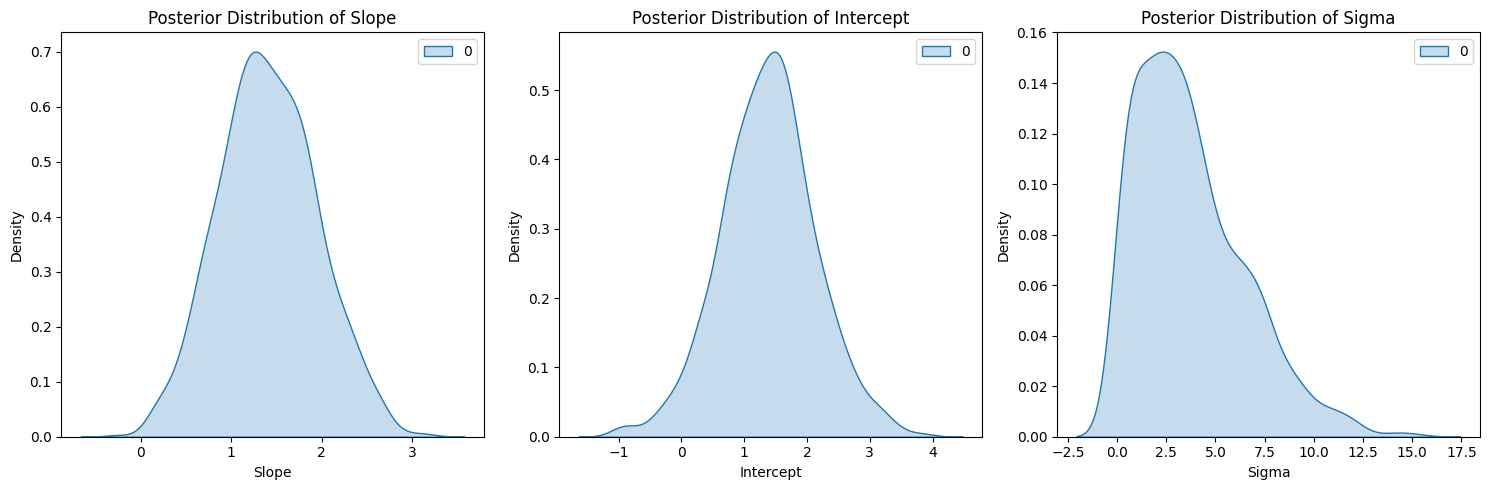

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.kdeplot(slope_samples, shade=True, ax=axs[0])
axs[0].set_title("Posterior Distribution of Slope")
axs[0].set_xlabel("Slope")
axs[0].set_ylabel("Density")

sns.kdeplot(intercept_samples, shade=True, ax=axs[1])
axs[1].set_title("Posterior Distribution of Intercept")
axs[1].set_xlabel("Intercept")
axs[1].set_ylabel("Density")

sns.kdeplot(sigma_samples, shade=True, ax=axs[2])
axs[2].set_title("Posterior Distribution of Sigma")
axs[2].set_xlabel("Sigma")
axs[2].set_ylabel("Density")

plt.tight_layout()
plt.show()